In [1]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from IPython.display import Image as im
style.use('fivethirtyeight')

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [2]:
stopwords.append('inquirer')
stopwords.append('cookies')
stopwords.append('repo')
stopwords.append('exec')
stopwords.append('dutee')
stopwords.append('said')

In [3]:
df = pd.read_csv('./Scraped/ejks.csv')

# Cleaning

In [4]:
def clean_text(df):
    df['cleaned_text'] = df['narrative'].fillna('')
    df['cleaned_text'] = df['cleaned_text'].str.lower()
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|rt|\d+', '')
    df['cleaned_text'] = df['cleaned_text'].str.replace(r'^\s+|\s+$', '') 
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in (stopwords)]))
    df['cleaned_split'] = df['cleaned_text'].apply(lambda x: x.split())
    return df

In [5]:
def lemmatize_df(df):
    df['lemmatized'] = df['cleaned_split'].apply(lambda x : [lemmatizer.lemmatize(word) for word in x])
    return df

In [6]:
df = clean_text(df)
df = lemmatize_df(df)

In [7]:
df.head()

,Unnamed: 0,url,title,time,narrative,cleaned_text,cleaned_split,lemmatized
0,0,https://newsinfo.inquirer.net/1198980/icc-upda...,ICC update gives ‘glimmer of hope’ for EJK vic...,"06:15 AM December 07, 2019",BONDING IN GRIEF Families from urban poor comm...,bonding grief families urban poor communities ...,"[bonding, grief, families, urban, poor, commun...","[bonding, grief, family, urban, poor, communit..."
1,1,https://newsinfo.inquirer.net/1210965/46-slain...,46 slain in Soccsksargen’s war on drugs in 2019,"05:19 PM January 09, 2020",GENERAL SANTOS CITY –– The number of drug susp...,general santos city number drug suspects slain...,"[general, santos, city, number, drug, suspects...","[general, santos, city, number, drug, suspect,..."
2,2,https://newsinfo.inquirer.net/1276004/drug-war...,Drug war killings rose in Central Visayas unde...,"08:37 AM May 16, 2020","Brig. Gen. Debold Sinas, director of the Natio...",brig gen debold sinas director national capita...,"[brig, gen, debold, sinas, director, national,...","[brig, gen, debold, sinas, director, national,..."
3,3,https://newsinfo.inquirer.net/1008295/killings...,‘Killings create climate of lawlessness’ – LP,"07:25 AM July 09, 2018",POLITICS EYED Police say politics may be behin...,politics eyed police say politics may behind k...,"[politics, eyed, police, say, politics, may, b...","[politics, eyed, police, say, politics, may, b..."
4,4,https://newsinfo.inquirer.net/1043822/soccsksa...,Soccsksargen death toll in war on drugs: 270,"05:33 AM October 17, 2018",GENERAL SANTOS CITY — President Rodrigo Dutert...,general santos city president rodrigo dutees b...,"[general, santos, city, president, rodrigo, du...","[general, santos, city, president, rodrigo, du..."


# Analysis

In [8]:
def tweets_to_dtm(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/dtm.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_ngram(tweets, n=2):
    tweets = tweets['cleaned_text']
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000)
    dtm = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/ngram.pk', 'wb'))
    return dtm, vectorizer

def tweets_to_tfidf(tweets):
    tweets = tweets['cleaned_text']
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(tweets)
    pickle.dump(vectorizer, open('out/tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [9]:
# Get TFIDF matrix
tfidf, tfidf_v = tweets_to_tfidf(df)
print('TFIDF matrix shape:', tfidf.toarray().shape)
list(tfidf_v.vocabulary_.items())[0:5]

TFIDF matrix shape: (371, 2000)


[('grief', 742),
 ('families', 633),
 ('poor', 1355),
 ('communities', 361),
 ('lost', 1024)]

In [10]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [11]:
freq_tfidf = vector_to_frequency(tfidf, tfidf_v)
freq_tfidf.to_csv('out/frequency_tfidf.csv', index=False)
freq_tfidf.head(20)

,term,frequency
0,police,26.826991
1,drug,23.719320
2,get,14.973165
3,use,14.948563
4,killed,14.939092
5,share,14.628808
6,city,14.293100
7,killings,13.970104
8,barangay,13.714497
9,shot,12.971858


Text(0.5, 1.0, 'Frequent terms in TFIDF')

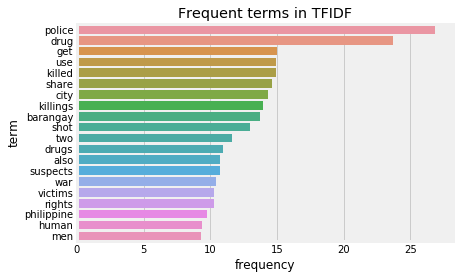

In [12]:
# Visualize frequencies
sns.barplot(data=freq_tfidf.head(20), x='frequency',
            y='term').set_title('Frequent terms in TFIDF')

In [13]:
df['label'] = 'ejks'

In [14]:
df.head()

,Unnamed: 0,url,title,time,narrative,cleaned_text,cleaned_split,lemmatized,label
0,0,https://newsinfo.inquirer.net/1198980/icc-upda...,ICC update gives ‘glimmer of hope’ for EJK vic...,"06:15 AM December 07, 2019",BONDING IN GRIEF Families from urban poor comm...,bonding grief families urban poor communities ...,"[bonding, grief, families, urban, poor, commun...","[bonding, grief, family, urban, poor, communit...",ejks
1,1,https://newsinfo.inquirer.net/1210965/46-slain...,46 slain in Soccsksargen’s war on drugs in 2019,"05:19 PM January 09, 2020",GENERAL SANTOS CITY –– The number of drug susp...,general santos city number drug suspects slain...,"[general, santos, city, number, drug, suspects...","[general, santos, city, number, drug, suspect,...",ejks
2,2,https://newsinfo.inquirer.net/1276004/drug-war...,Drug war killings rose in Central Visayas unde...,"08:37 AM May 16, 2020","Brig. Gen. Debold Sinas, director of the Natio...",brig gen debold sinas director national capita...,"[brig, gen, debold, sinas, director, national,...","[brig, gen, debold, sinas, director, national,...",ejks
3,3,https://newsinfo.inquirer.net/1008295/killings...,‘Killings create climate of lawlessness’ – LP,"07:25 AM July 09, 2018",POLITICS EYED Police say politics may be behin...,politics eyed police say politics may behind k...,"[politics, eyed, police, say, politics, may, b...","[politics, eyed, police, say, politics, may, b...",ejks
4,4,https://newsinfo.inquirer.net/1043822/soccsksa...,Soccsksargen death toll in war on drugs: 270,"05:33 AM October 17, 2018",GENERAL SANTOS CITY — President Rodrigo Dutert...,general santos city president rodrigo dutees b...,"[general, santos, city, president, rodrigo, du...","[general, santos, city, president, rodrigo, du...",ejks


In [17]:
df.to_pickle('./Cleaned/ejks_cleaned.pkl')